In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import glob
from sklearn.utils import shuffle
from tqdm import tqdm_notebook
import pandas as pd
import numpy as np
import nibabel as nib
from scipy.ndimage import gaussian_filter as gf
from scipy import ndimage

In [ ]:
import shutil
shutil.unpack_archive("/content/drive/MyDrive/Slices.zip", "slices")
#hist= np.load("/content/drive/MyDrive/hist.npy")

In [ ]:
!mv slices/content/slices/imagesTr slices
!mv slices/content/slices/labelsTr slices
!rm -r slices/content

In [ ]:
import json

# Serialize data into file:
#json.dump( class_dic, open( "/content/drive/MyDrive/class_dic.json", 'w' ) )

# Read data from file:
class_dic = json.load( open( "/content/drive/MyDrive/class_dic.json" ) )

In [ ]:
"""
class_dic ={}
for i in range(1, 485):
  for j in range(155):
    id= str(i).zfill(3)+'_'+str(j).zfill(3)
    path= '/content/slices/labelsTr/'+id+'.npz'
    label= np.load(path)['img']
    class_dic[id]= [1 in label, 2 in label, 3 in label]
"""  
"""
hist= np.zeros((3, 3, 20000))
for path in glob.glob("/content/slices/imagesTr/*.npz"):
  img= np.load(path)['img']
  label= np.load(path.replace('imagesTr','labelsTr'))['img']
  for idx, x in np.ndenumerate(label):
    if x>0:
      for i in range(3):
        pixel= int(img[idx[0], idx[1], i])
        hist[i, int(x-1), pixel]+=1
np.save("/content/drive/MyDrive/hist.npy", hist)
index= hist.shape[2]-1
for i in range(hist.shape[2]-1, 0, -1):
  if np.sum(hist[:, :, i])>0:
    index= i+1
    break
hist= hist[:, :, index+1] 
"""        

75020


In [ ]:
"""
import glob
for path in glob.glob("/content/Data/imagesTr/*.nii.gz"):
    start_ind= path.index("_")+1
    subj= path[start_ind:start_ind+3]
    nii_data  = nib.load(path).get_fdata()[:, :, :, [0,2,3]]
    nii_mask  = nib.load(path.replace("imagesTr","labelsTr")).get_fdata()
    for j in range(nii_mask.shape[2]):
        img0 = np.array(nii_data[:, :, j,:],dtype='int16')
        mask0 = np.array(nii_mask[:,:,j],dtype='int16')
        np.savez_compressed('/content/slices/imagesTr/' + subj+ '_' +str(j).zfill(3)+'.npz',img=img0 )
        np.savez_compressed('/content/slices/labelsTr/' + subj+ '_' +str(j).zfill(3)+'.npz',img=mask0)
#drive.mount('/content/drive')
!zip -r /content/drive/MyDrive/Slices.zip /content/slices/imagesTr /content/slices/labelsTr
#drive.flush_and_unmount()
"""

Mounted at /content/drive


In [ ]:
print(all_area/484)

[0.         0.0072797  0.00202066 0.00226994]


In [ ]:
# !pip -q install monai
# !pip -q install 'monai[all]'
!pip install segmentation-models-pytorch
#!pip install git+https://github.com/qubvel/segmentation_models.pytorch

     |████████████████████████████████| 87 kB 4.9 MB/s 
     |████████████████████████████████| 376 kB 49.6 MB/s 
     |████████████████████████████████| 58 kB 7.5 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=2b19174994a76a704fce6bab6cc3578ddac43fd47c460f99a6cbb455fc5fefbe
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=df283248cefa3dbe55c09dd8c2d8d87ee0835f56724a889eff4546bc9c935f2b
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
import math
def get_mean_std(arr):
  mean= 0
  sample_size= np.sum(arr)
  for i in range(len(arr)):
    mean= mean+i*arr[i]/1000
  mean/=(sample_size/1000)
  std= math.sqrt(np.sum((arr-mean)**2)/sample_size)
  return mean, std

In [ ]:
for i in range(3):
  arr= hist[i, :, :]
  arr= arr.sum(axis=0)
  print(get_mean_std(arr))

(725.0646853217143, 215.5978434329118)
(656.8435915424164, 218.2960317375785)
(688.5045511617043, 229.1554367546339)


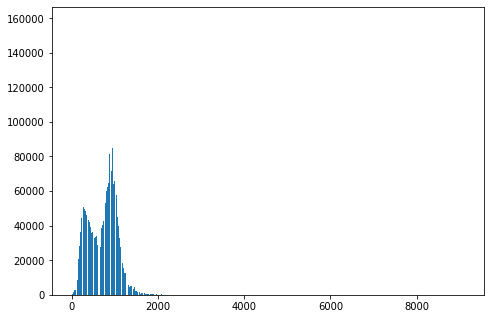

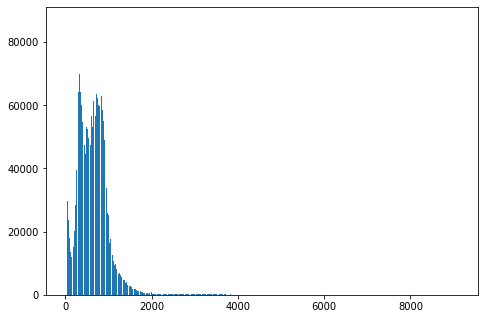

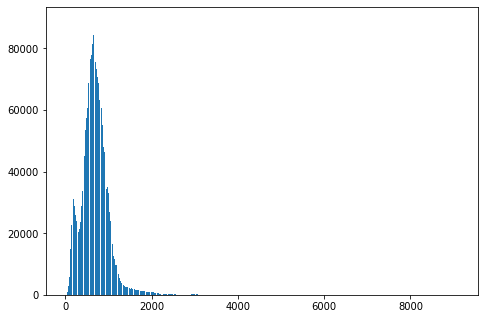

In [ ]:
import matplotlib.pyplot as plt
for i in range(3):
  arr= hist[i, :, :]
  arr= arr.sum(axis=0)
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  pixel_vals= np.arange(len(arr))
  ax.bar(pixel_vals, arr)
  plt.show()

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
# from monai import transforms
# from monai.config import print_config
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise, CLAHE)
from albumentations.pytorch import ToTensor

# from monai.metrics import compute_roc_auc

import sys
import glob

def window(img, mean= 725, std= 215):
    upper, lower = mean+4*std, mean-4*std
    X = np.clip(img.copy(), lower, upper)
    X = X - np.min(X)
    X = X / (np.max(X)/255.0)
    #X = cv2.merge([X,X,X])
    X = X.astype('uint8')
    #clahe = cv2.createCLAHE(clipLimit=10, tileGridSize=(8,8))
    #X = clahe.apply(X)
    return X

%matplotlib inline
np.random.seed(0)
# print_config()

In [ ]:
for i in range(1, 485):
  for j in range(155):
    id= str(i).zfill(3)+'_'+str(j).zfill(3) 
    path= '/content/slices/labelsTr/'+id+'.npz'
    label= np.load(path)['img']
    label[label!=1]= 0
    #label[label==3]= 1
    np.savez_compressed(path, img= label)

In [ ]:
from sklearn.model_selection import train_test_split
import glob

train_subject,test_subject = train_test_split(np.arange(1, 485), test_size=0.2, random_state=0)
#train_subject= np.load('/content/drive/MyDrive/tr1.npy')
#test_subject= np.load('/content/drive/MyDrive/ts1.npy')
has_label= 0
no_label= 0
train_slices = []
for i in train_subject:
  for path in glob.glob('/content/slices/imagesTr/'+str(i).zfill(3)+'*.npz'):
    id= path.split("/")[4].split(".")[0]
    if class_dic[id][0]==False:
      if no_label<.2*has_label:
        no_label= no_label+1
      else:
        continue
    else:
      has_label= has_label+1
    train_slices.append(path)       
has_label= 0
no_label= 0
test_slices = []
for i in test_subject:
  for path in glob.glob('/content/slices/imagesTr/'+str(i).zfill(3)+'*.npz'):
    id= path.split("/")[4].split(".")[0]
    if class_dic[id][0]==False:
      if no_label<.2*has_label:
        no_label= no_label+1
      else:
        continue
    else:
      has_label= has_label+1
    test_slices.append(path)
test_slices = sorted(test_slices)
len(train_slices),len(test_slices)
#np.save('/content/drive/MyDrive/tr1.npy', train_subject)
#np.save('/content/drive/MyDrive/ts1.npy', test_subject)

(32164, 8130)

/content/slices/imagesTr/327_078.npz


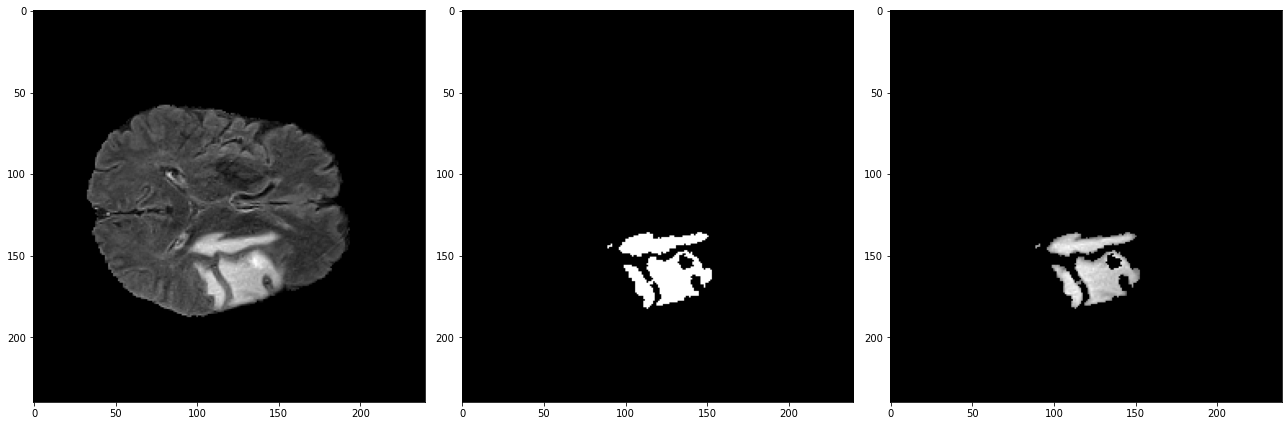

In [ ]:
i = 4301

img = np.load(train_slices[i])['img']

mask =np.load(train_slices[i].replace('imagesTr','labelsTr'))['img']

print(train_slices[i])
slice_img = window(img)[:, :, 0]
slice_mask = mask
masked = np.array(slice_img)
masked[slice_mask==0]=0

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow(slice_img, cmap='gray')

plt.subplot(1,3,2)
plt.imshow(slice_mask, cmap='gray')

plt.subplot(1,3,3)
plt.imshow(masked, cmap='gray')

plt.tight_layout()
plt.show()

In [ ]:
def get_transforms(phase, size, mean, std):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
                HorizontalFlip(),
                ShiftScaleRotate(
                    shift_limit=0,  # no resizing
                    scale_limit=0.1,
                    rotate_limit=10, # rotate
                    p=0.5,
                    border_mode=cv2.BORDER_CONSTANT
                ),
#                 GaussNoise(),
            ]
        )
    list_transforms.extend(
        [
            Resize(size, size),
            Normalize(mean=mean, std=std, p=1),
            ToTensor()
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms

class CustomDataSet(Dataset):
    def __init__(self, files_list, size, mean, std, phase):
        self.size = size
        self.mean = mean
        self.std = std
        self.phase = phase
        self.transforms = get_transforms(phase, size, mean, std)
        self.fnames = files_list

    def __getitem__(self, idx):
        image_path = self.fnames[idx]
        image = window(np.load(image_path)['img'])
        image = image.astype(float)
        mask = np.load(image_path.replace('imagesTr','labelsTr'))['img']
        mask = mask.astype(float)
        image= image[46:191,26:211,:]
        mask= mask[46:191,26:211]
        augmented= self.transforms(image= image, mask= mask)
        image = augmented['image']
        mask = augmented['mask']
        return image, mask

    def get_image(self, path):
        image_path = path
        image = window(np.load(image_path)['img'])
        image = image.astype(float)
        mask = np.load(image_path.replace('imagesTr','labelsTr'))['img']
        mask = mask.astype(float)
        image= image[46:191,26:211,:]
        mask= mask[46:191,26:211]
        augmented= self.transforms(image= image, mask= mask)
        image = augmented['image']
        mask = augmented['mask']
        return image, mask     
    
    def __len__(self):
        return len(self.fnames)


phase = 'train'
size=192
mean=(0.449)
std=(0.226)
batch_size=32
num_workers=1

train_ds = CustomDataSet(train_slices, size, mean, std, phase)
train_loader = DataLoader(train_ds, batch_size= batch_size, shuffle=True, num_workers=num_workers)

phase='test'
val_ds = CustomDataSet(test_slices, size, mean, std, phase)
val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=num_workers)
for batch_data in train_loader:
  print(type(batch_data))
  break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


<class 'list'>


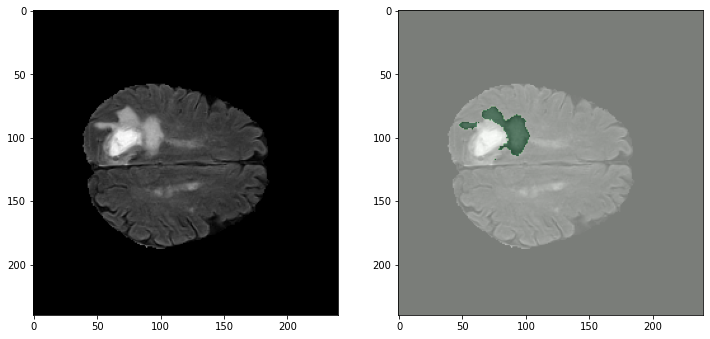

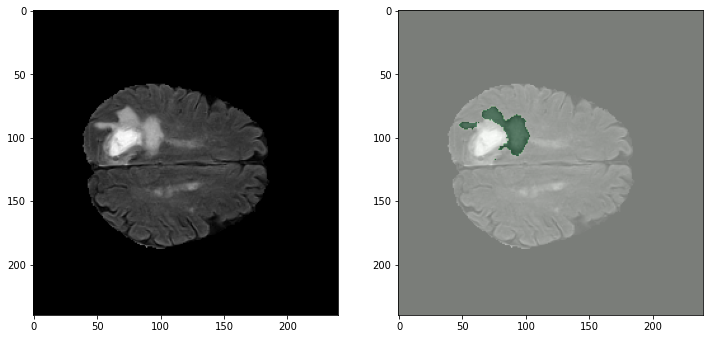

(4, 192, 192) (1, 192, 192)


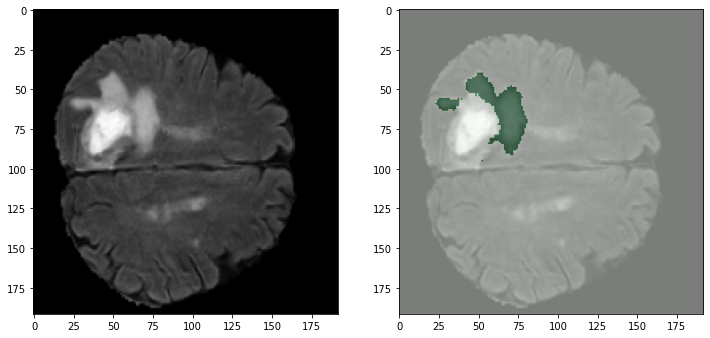

In [ ]:
def show(img, mask):
  plt.figure(figsize=(12,36))
  plt.subplot(1,2,1)
  plt.imshow(img, cmap='gray')
  plt.subplot(1,2,2)
  plt.imshow(img, cmap='gray')
  plt.imshow(mask, alpha=0.5, cmap='Greens')
  plt.show()

fil= '/content/slices/imagesTr/436_100.npz'
img= np.load(fil)['img']
mask= np.load(fil.replace('imagesTr','labelsTr'))['img']
show(img[:, :, 0], mask)
show(window(img[:, :, 0]), mask)
img, mask= val_ds.get_image(fil)
img, mask= img.cpu().detach().numpy(), mask.cpu().detach().numpy()
print(img.shape, mask.shape)
show(img[0,:,:], mask[0, :, :])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


torch.Size([32, 1, 192, 192])


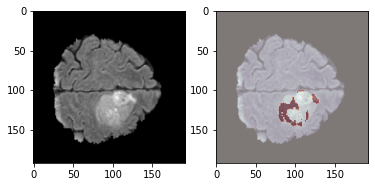

torch.Size([32, 1, 192, 192])


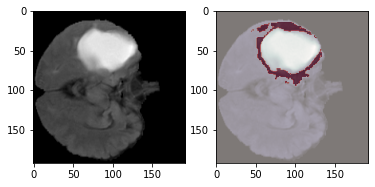

torch.Size([32, 1, 192, 192])


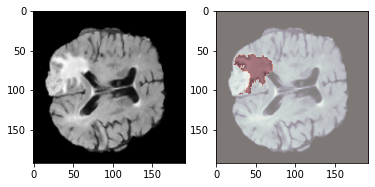

torch.Size([32, 1, 192, 192])


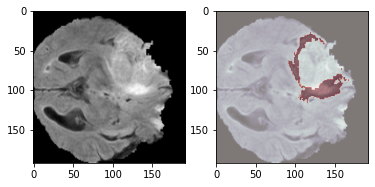

torch.Size([32, 1, 192, 192])


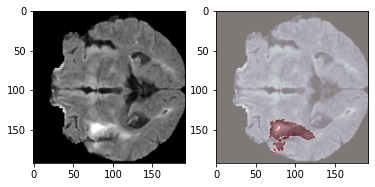

torch.Size([32, 1, 192, 192])


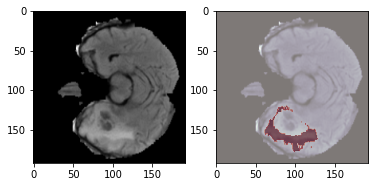

In [ ]:
batch = next(iter(train_loader)) 
images, masks = batch
for idx in range(8):
  if len(np.unique(masks[idx][0])) > 1:
    print(masks.shape)
    plt.subplot(1,2,1)
    plt.imshow(images[idx][0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(images[idx][0], cmap='bone')
    plt.imshow(masks[idx][0], alpha=0.5, cmap='Reds')
    plt.show()

In [ ]:
images.shape, masks.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 256, 256]))

In [ ]:
try:
  device = torch.device("cuda:0")
  print('run with gpu')
except:
  device = torch.device("cpu")
# import collections.abc as container_abcs
import segmentation_models_pytorch as smp
n_classes = 1
activation = 'sigmoid' if n_classes == 1 else 'softmax'
model = smp.Unet(
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    #encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    encoder_weights= None,
    in_channels=4,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
    activation=activation
).to(device)

# print(model)

run with gpu


In [ ]:
bce_loss = torch.nn.BCELoss()

def dice_loss(pred,target):
    numerator = 2 * torch.sum(pred * target)
    denominator = torch.sum(pred + target)
    return  1 - (numerator + 1) / (denominator + 1)

def bce_dice_loss(pred,target):
  return bce_loss(pred,target) + dice_loss(pred,target)

loss_function = bce_dice_loss

optimizer = torch.optim.Adam(model.parameters(), 1e-3,weight_decay=0)

epoch_num = 100
val_interval = 1
  
steps = epoch_num#int(len(train_slices)/batch_size)+1
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, steps)

In [ ]:
from torch.autograd import Variable

def my_dice(y_pred,y_true,device='cpu',thr=0.5):
    thr = Variable(torch.Tensor([thr])).to(device)  
    y_pred = (y_pred > thr).float() * 1
    smooth = 1e-4
    iflat = y_pred.view(-1)
    tflat = y_true.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

In [ ]:
# Dice for all subjects in val and test

In [ ]:
best_metric = -1
best_metric_epoch = -1
not_improving= 0
epoch_loss_values = list()
metric_values = list()
# Add F1 score
# Test augmentations
# alaa package for augmentation
# Resize after crop if necessary, plot a sample after crop
for epoch in range(epoch_num):
    if not_improving==10:
      break
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader: 

        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = 1+(len(train_ds) // train_loader.batch_size)

        sys.stdout.write('\r'+f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)

    print('\n',f"###### epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            dice_metric= 0
            for i in test_subject:
              y_pred = torch.tensor([], dtype=torch.float32, device=device)
              y = torch.tensor([], dtype=torch.long, device=device)
              for j in range(155):
                id= str(i).zfill(3)+'_'+str(j).zfill(3)
                path= '/content/slices/imagesTr/'+id+'.npz'
                val_image, val_label = val_ds.get_image(path)
                val_image, val_label= val_image.cuda(), val_label.cuda()
                y_pred= torch.cat((y_pred, model(val_image[None,...])),0)
                y= torch.cat((y, val_label), 0)
              dice_metric = dice_metric+my_dice(y_pred, y,device=device,thr=0.5)
            dice_metric/=len(test_subject)
            metric_values.append(dice_metric)
            if dice_metric > best_metric:
                not_improving= 0
                best_metric = dice_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), '/content/drive/MyDrive/model2D-1.pth')
                print('###### Congratulations ###### saved new best metric model')
            else:
                not_improving+=1    
            print(f"current epoch: {epoch + 1} current DICE: {dice_metric:.4f}"
                  f" at epoch: {best_metric_epoch}")
        scheduler.step()
        print('The learning rate updated to :',scheduler.get_lr()[0])
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

----------
epoch 1/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


1006/1006, train_loss: 0.1622
 ###### epoch 1 average loss: 0.3898


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


###### Congratulations ###### saved new best metric model
current epoch: 1 current DICE: 0.6428 at epoch: 1
The learning rate updated to : 0.0009995066212363998
----------
epoch 2/100


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:509: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


1006/1006, train_loss: 0.4246
 ###### epoch 2 average loss: 0.2812
###### Congratulations ###### saved new best metric model
current epoch: 2 current DICE: 0.6951 at epoch: 2
The learning rate updated to : 0.000998273995856153
----------
epoch 3/100
1006/1006, train_loss: 0.2417
 ###### epoch 3 average loss: 0.2495
###### Congratulations ###### saved new best metric model
current epoch: 3 current DICE: 0.7127 at epoch: 3
The learning rate updated to : 0.0009965501206540706
----------
epoch 4/100
1006/1006, train_loss: 0.3925
 ###### epoch 4 average loss: 0.2313
current epoch: 4 current DICE: 0.7085 at epoch: 3
The learning rate updated to : 0.0009943366965261377
----------
epoch 5/100
1006/1006, train_loss: 0.1873
 ###### epoch 5 average loss: 0.2189
###### Congratulations ###### saved new best metric model
current epoch: 5 current DICE: 0.7345 at epoch: 5
The learning rate updated to : 0.0009916359074934001
----------
epoch 6/100
1006/1006, train_loss: 0.2010
 ###### epoch 6 average l

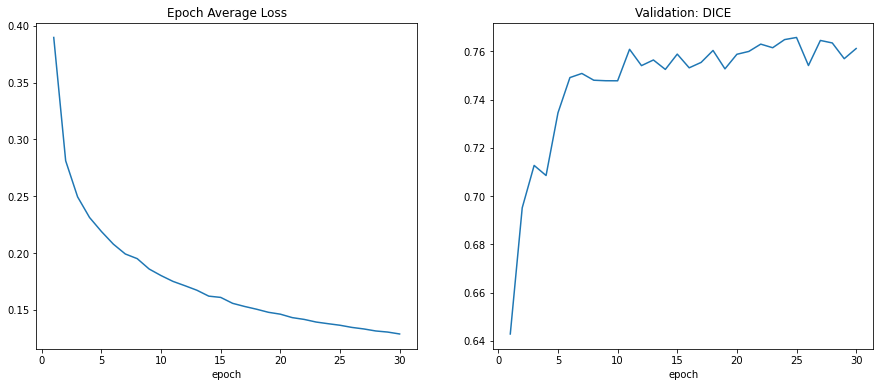

In [ ]:
plt.figure('train', (15, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Validation: DICE")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.show()

In [ ]:
# Scipy zoom mask for test data
# Best fold model
# Mean models
model.load_state_dict(torch.load('/content/drive/MyDrive/model2D-1.pth'))
model.eval()
y_true = list()
y_pred = list()
# y_new_pred = list()
with torch.no_grad():
    for val_data in val_loader:
        test_images, test_labels = val_data[0].to(device), val_data[1].to(device)
        pred = model(test_images)
        # new_pred = pred.argmax(dim=1)

        for i in range(len(pred)):
            y_true.append(test_labels[i].cpu().detach().numpy())
            y_pred.append(pred[i].cpu().detach().numpy())
            # y_new_pred.append(new_pred[i].cpu().detach().numpy())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true.shape,y_pred.shape

((1860, 1, 256, 256), (1860, 1, 256, 256))

          Raw Images        ,       True Mask(green)      ,   Prediction Mask(Red)


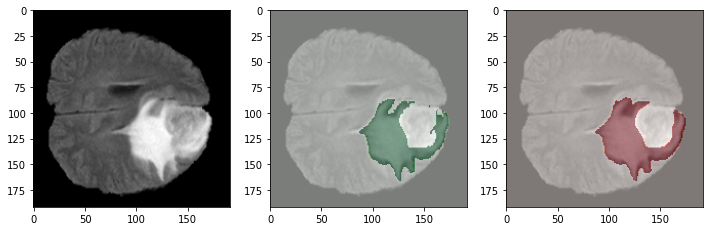

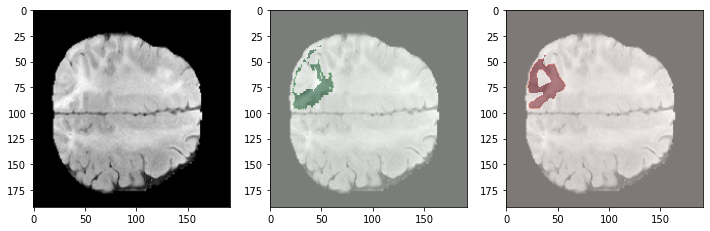

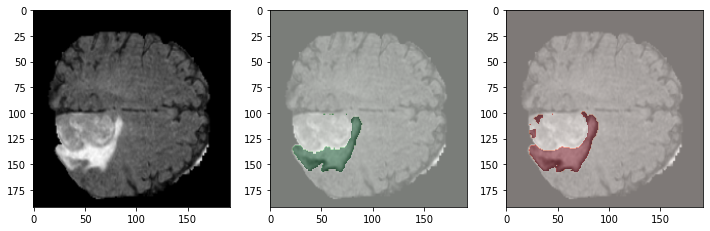

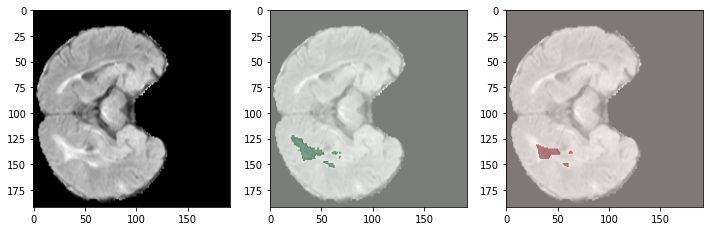

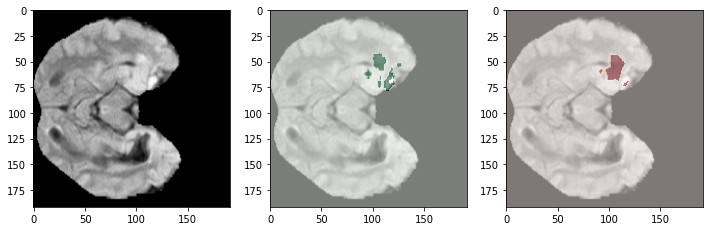

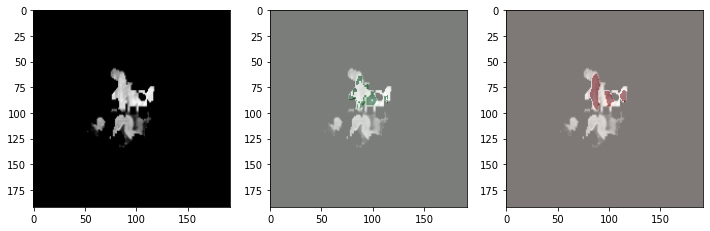

In [ ]:
n_sample = 8

samples = np.random.randint(1,8131,n_sample)

images, masks, predict = [],[],[]
for sample in samples:
  #images.append(cv2.resize(np.load(np.array(test_slices)[sample])['img'],(size,size)))
  image, mask= val_ds.get_image(np.array(test_slices)[sample])
  image= image.cpu().detach().numpy()[0, :, :]
  images.append(image)
  masks.append(y_true[sample][0])
  predict.append(y_pred[sample][0]>0.5)

print('          Raw Images        ,       True Mask(green)      ,   Prediction Mask(Red)')
for idx in range(n_sample):
  if np.sum(masks[idx])+np.sum(predict[idx]) > 10:
    plt.figure(figsize=(12,36))
    plt.subplot(1,3,1)
    plt.imshow(images[idx], cmap='gray')
    plt.subplot(1,3,2)
    plt.imshow(images[idx], cmap='gray')
    plt.imshow(masks[idx], alpha=0.5, cmap='Greens')
    plt.subplot(1,3,3)
    plt.imshow(images[idx], cmap='gray')
    plt.imshow(predict[idx], alpha=0.5, cmap='Reds')
    plt.show()